# Invariant Ring Slot Attention Superivsed

**Motivation:** In the `Invariant-Ring-SA` notebook, I built the first Invariant Rings Slot Attention model, but it seems quite sensitive to the initial guesses for the rings to learn something _non-trivial_.

I think the next good thing to try is to learn these $q$ vectors in a supervised way, which to be honest is something that had been on my short term "to do" list anyways for awhile, so I think the setup in this notebook will translate easily into some other problems too!!

In [24]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from torch.nn import init
from train import train

import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
device='cuda:1'
hps = {
    'hidden_dim': 16,
    'k_slots':3,
    'query_dim':3,
    'pixel_mult':0.2,
    'device':device
}

In [212]:
class RingSlotAttention(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 xlow=-0.5,
                 xhigh=0.5,
                 varlow=0.01,
                 varhigh=0.05,
                 k_slots=3, 
                 num_conv_layers=3,
                 hidden_dim=32, 
                 final_cnn_relu=False,
                 rnn_dim=32,
                 query_dim=3, 
                 n_iter=2,
                 pixel_mult=1,
                 device='cpu' 
                 ):
        '''
        Slot attention encoder block, block attention
        '''
        super().__init__()

        assert query_dim == 3
        
        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.rnn_dim = rnn_dim
        self.n_iter = n_iter

        self.resolution = resolution
        self.xlow, self.xhigh = xlow, xhigh
        self.rlow, self.rhigh = np.sqrt(varlow), np.sqrt(varhigh)
        
        self.device=device
         
        self.softmax_T = 1/np.sqrt(query_dim)
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        
        self.toV = torch.nn.Linear(self.hidden_dim, self.rnn_dim)
        self.gru = torch.nn.GRUCell(self.rnn_dim, self.query_dim)

        # CNN
        kwargs = {'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }
        cnn_layers = [torch.nn.Conv2d(1,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
            
        if final_cnn_relu:
            cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
            
        # Grid + query init
        self.abs_grid = self.build_grid()
                   
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)

        self.init_slots = self.init_slots

    def build_grid(self):
        '''
        From google slot attention repo:
        https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L357C1-L364C53
        '''
        resolution = self.resolution
        xlow, xhigh = self.xlow, self.xhigh
           
        ranges = [np.linspace(xlow, xhigh, num=res) for res in resolution]
        grid = np.meshgrid(*ranges, sparse=False, indexing="xy")
        grid = np.stack(grid, axis=-1)
        grid = np.reshape(grid, [resolution[0], resolution[1], -1])
        grid = np.expand_dims(grid, axis=0)
        
        grid = torch.FloatTensor( grid ).to(self.device)
        grid = torch.flatten(grid,1,2)
    
        return grid
                
    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        queries = mu + sigma * torch.randn(mu.shape, device=self.device)

        # Scale the output by the anticipated boundaries
        # queries = torch.nn.Tanh()(queries)
        # queries = self.scale_output(queries)
        
        return queries
     
    def scale_output(self, tq):
        '''
        For input tq in (0,1) bound the output:
        - dim 0,1 from xlow, xhigh
        - dim 2 from rlow, rhigh
        '''
        
        z = 0.5 * (tq + 1) # goes from (0,1)
        
        xy = (self.xhigh - self.xlow) * z[:,:,:2] + self.xlow
        r  = (self.rhigh - self.rlow) * z[:,:,-1] + self.rlow
        
        return torch.cat([xy,r.unsqueeze(-1)],dim=-1)
        
    def attention_and_weights(self,queries):
        
        Nbatch = queries.shape[0]
        xy_grid = self.abs_grid
        
        xy_slots = queries[:,:,:2]
        r_slots = queries[:,:,-1]
        
        # Calculate the vector from the cirlce center -> xy
        logits = xy_slots.unsqueeze(2) - xy_grid.unsqueeze(1)
        
        # Take the length of this vector (L2 norm)
        logits = torch.sqrt(torch.sum(logits**2,axis=-1))

        # Subtract r
        logits = torch.abs( logits - r_slots.unsqueeze(-1) )

        att = torch.nn.functional.softmax(- self.softmax_T * logits, dim = 1)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts
        
    def iterate(self, queries, encoded_data):
        
        # att,wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(queries)   
        
        vals = self.toV(encoded_data)
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.rnn_dim),
            queries.reshape(-1,self.query_dim),
        )
        
        
        return self.scale_output(updates.reshape(queries.shape))

    def forward(self, data):
    
        # Step 1: Get the encoded data
        encoded_data = self.CNN_encoder(data) # apply the CNN encoder
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) # channel dim at the end
        encoded_data = torch.flatten(encoded_data,1,2) # flatten the pixel dims
    
        # Step 2: Initialize the slots
        Nbatch = data.shape[0]
        queries = self.init_slots(data.shape[0]) 
        
        # Step 3: Iterate through the reconstruction
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # With the final query vector, calc the attn, weights, + rel ref frames
        att, wts = self.attention_and_weights(queries)   
        
        return queries, att, wts 

In [213]:
m = RingSlotAttention(**hps).to(device)

In [214]:
bs = 2
kwargs = {'isRing': True, 'N_clusters':2,'device':device}
X, Y, mask = make_batch(N_events=1000, **kwargs)

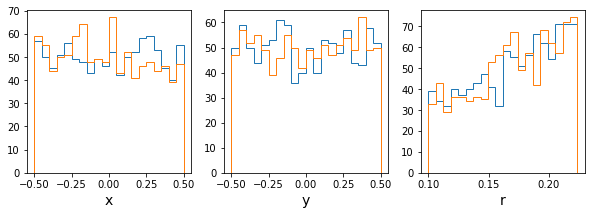

In [215]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

for i,axi,label,r in zip(range(3),ax,['x','y','r'],[(-.5,.5)]*2+[(np.sqrt(.01),np.sqrt(.05))]):
    axi.hist(Y[:,0,i].cpu().numpy(),20,r,histtype='step')
    axi.hist(Y[:,1,i].cpu().numpy(),20,r,histtype='step')
    axi.set_xlabel(label,fontsize=14)

Sanity check the reshaping.

In [216]:
# from copy import copy

# Y_new = copy(Y)
# Y_new = Y_new.reshape(-1,m.query_dim)
# Y_new = Y_new.reshape(Y.shape)

# fig, ax = plt.subplots(1,3,figsize=(10,3))

# for i,axi,label,r in zip(range(3),ax,['x','y','r'],[(-.5,.5)]*2+[(np.sqrt(.01),np.sqrt(.05))]):
#     axi.hist(Y_new[:,0,i].cpu().numpy(),20,r,histtype='step')
#     axi.hist(Y_new[:,1,i].cpu().numpy(),20,r,histtype='step')
#     axi.set_xlabel(label,fontsize=14)
    
# plt.show()

**Note:** The variance was distributed evenly, but we have more bigger radii than smaller radii.

**Tip for A. Karpathy:** Initialize the bias of the last layer to be the center of the distribution.

**Equations for GRU update**
$$
\begin{align}
r_t &= \sigma \left( W_{xr} x_t + W_{hr} h_{t-1} + b_r \right) \\
z_t &= \sigma \left( W_{xz} x_t + W_{hz} h_{t-1} + b_z \right) \\
\tilde{h}_t &= \tanh \left( W_{xh} x_t + W_{hh} (r_t \odot h_{t-1}) + b_h \right) \\
h_t &= z_t \odot h_{t-1} + (1-z_t) \odot \tilde{h}_t
\end{align}
$$

**Recall:**
- The inputs $x_t$ are the updates computed from the weighted values of the `encoded_data`
- The hidden state $h_t$ are the `queries `

I wasn't able to immediately identify how to set the biases of the queries, but from staring at these equations I realized it was pretty easy to rescale the outputs to be in the range that I wanted :) 


In [217]:
Y[:,:,i].cpu().numpy().mean()

0.1702117

In [218]:
with torch.no_grad():
    queries, att,wts = m(X)
queries.shape

torch.Size([1000, 3, 3])

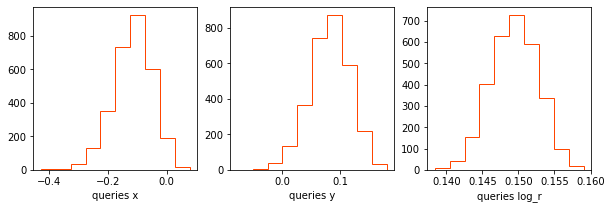

In [219]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

for i,axi,label in zip(range(3),ax,['x','y','log_r']):

    axi.hist(queries[:,:,i].detach().cpu().flatten().numpy(),
             histtype='step',color='orangered')
    axi.set_xlabel(f'queries {label}')
    
plt.show()

In [220]:
queries.shape

torch.Size([1000, 3, 3])

In [221]:
Y.shape

torch.Size([1000, 2, 3])

In [222]:
from scipy.optimize import linear_sum_assignment

In [223]:
def hungarian_matching(pairwise_cost):
    '''
    Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
    indices = torch.LongTensor(np.array(indices))
    
    loss = 0
    for pi,(ri,ci) in zip(pairwise_cost,indices):
        loss += pi[ri,ci].sum()
    
    return indices 

In [229]:
from matplotlib.patches import Circle

def plot_chosen_slots(losses, mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+2,figsize=(3*(n_rings + 2) ,2.5))

    axs[0].plot(losses,color=color)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        # ax.axis('off')

    # Add on the target image
    axi = axs[1]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[2:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    if figname:
        plt.savefig(figname)

    plt.show()
    plt.close()

In [225]:
# plot_chosen_slots(losses,mask[iEvt].sum(axis=0), 
#                   att_img,rings_sorted[iEvt],slots_sorted[iEvt])

In [226]:
def train(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          decay_rate = 0.5,
          decay_steps = 50_000,
          losses = [],
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    train -- arguments copied from Lukas's fct (see train.py)
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    loss = torch.nn.MSELoss(reduction='none')
    model.train()
    
    k_slots = model.k_slots
    max_n_rings = kwargs['N_clusters']
    resolution = model.resolution
    kwargs['device'] = device

    start = len(losses)
    for i in range(start,start+Ntrain):

        learning_rate = base_learning_rate * decay_rate ** (i / decay_steps)
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        queries, att, wts = model(X)
            
        with torch.no_grad():
            
            pairwise_cost = loss(queries.unsqueeze(2), Y.unsqueeze(1)).mean(axis=-1)
            indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        slots_sorted = torch.cat([queries[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # Calculate the loss
        li = loss(slots_sorted,rings_sorted).sum(axis=1).mean()
        
        li.backward()
        opt.step()
        opt.zero_grad()

        losses.append(float(li))
        
        if i % plot_every == 0:
            print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_sorted  = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
            
            att_img = att_sorted[iEvt].reshape(max_n_rings,*resolution)

            plot_chosen_slots(losses,mask[iEvt].sum(axis=0), att_img,
                              rings_sorted[iEvt],slots_sorted[iEvt])
            
        if (i % save_every == 0) and modelDir:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)

    model.eval()
    return model,losses

iter 100 , loss 0.09530485 , lr 2.9958439983030868e-05


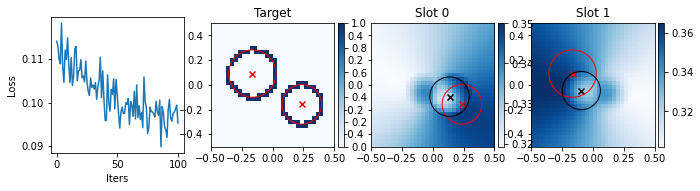

iter 200 , loss 0.093294665 , lr 5.983387508112417e-05


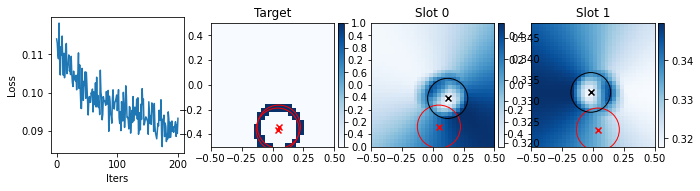

iter 300 , loss 0.07234946 , lr 8.962647777850122e-05


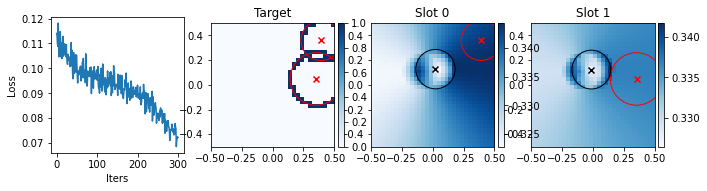

iter 400 , loss 0.067026414 , lr 0.00011933642024078572


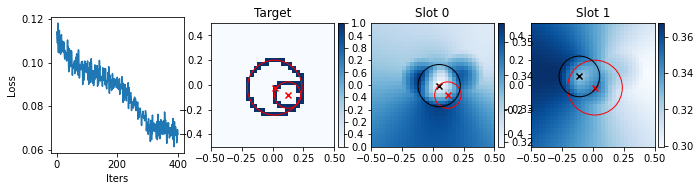

iter 500 , loss 0.062461685 , lr 0.00014896387431555537


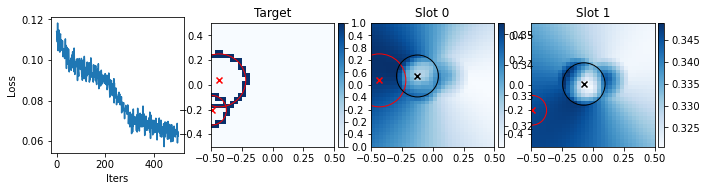

iter 600 , loss 0.06342159 , lr 0.00017850901153289276


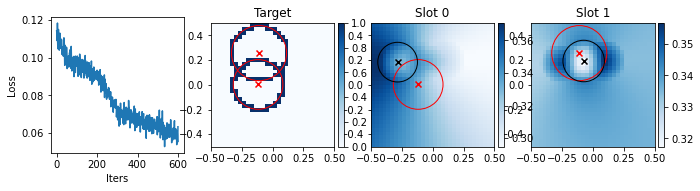

iter 700 , loss 0.05542826 , lr 0.00020797200310593514


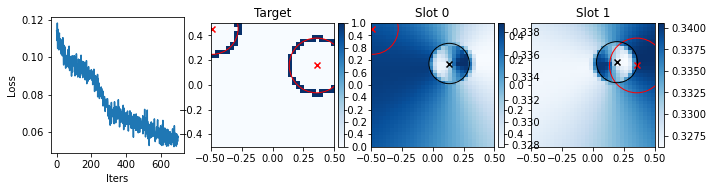

iter 800 , loss 0.055382412 , lr 0.00023735301993142353


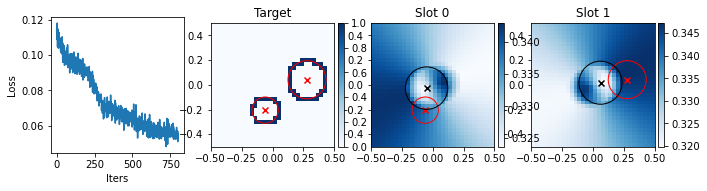

iter 900 , loss 0.05582253 , lr 0.0002666522325902506


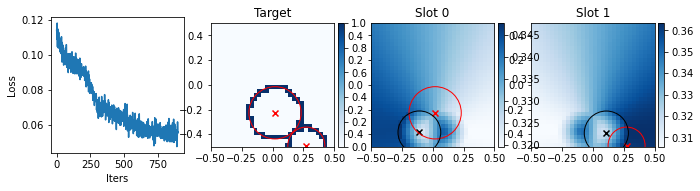

iter 1000 , loss 0.051019188 , lr 0.00029586981134800775


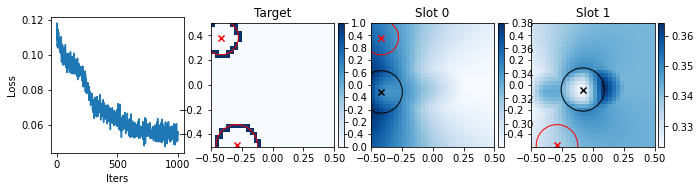

iter 1100 , loss 0.061750166 , lr 0.00029545993286866516


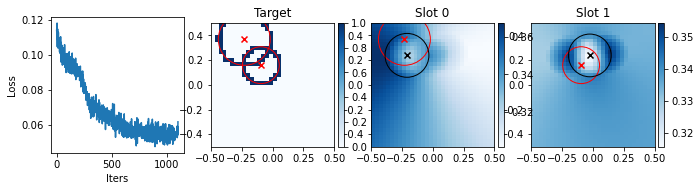

iter 1200 , loss 0.054375242 , lr 0.00029505062220787446


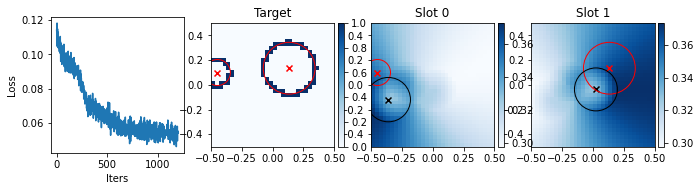

iter 1300 , loss 0.056857925 , lr 0.0002946418785790174


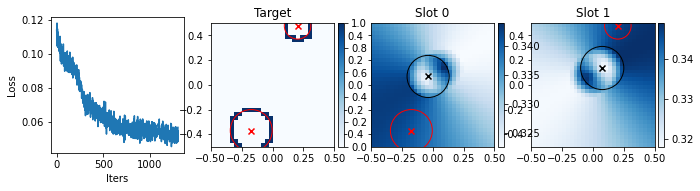

iter 1400 , loss 0.05420146 , lr 0.00029423370119656536


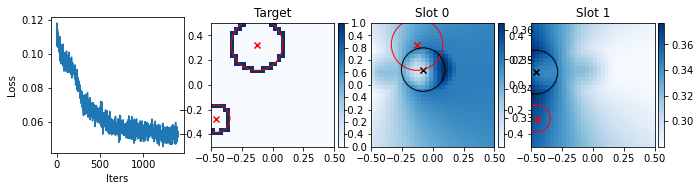

iter 1500 , loss 0.055840503 , lr 0.00029382608927607803


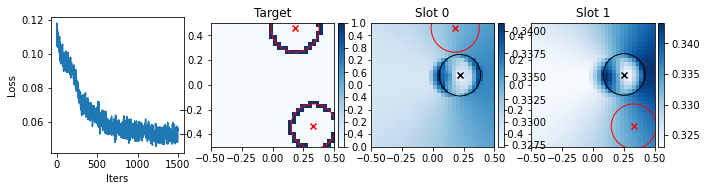

iter 1600 , loss 0.051333822 , lr 0.00029341904203420175


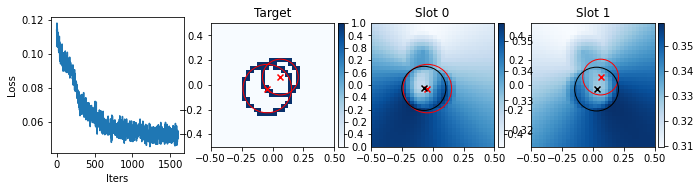

iter 1700 , loss 0.0456462 , lr 0.0002930125586886682


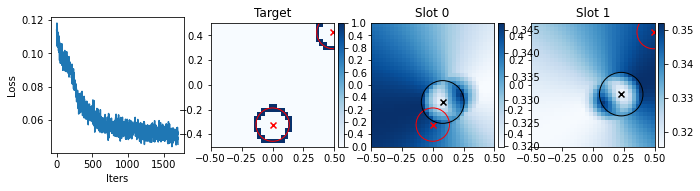

iter 1800 , loss 0.05474308 , lr 0.0002926066384582925


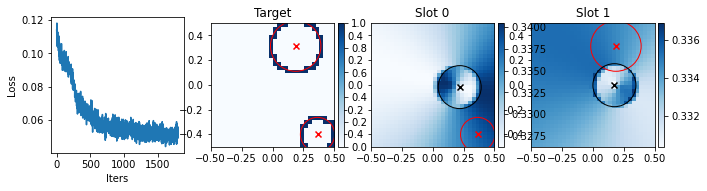

iter 1900 , loss 0.047749452 , lr 0.0002922012805629723


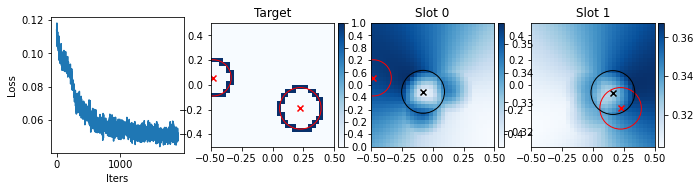

iter 2000 , loss 0.04853437 , lr 0.00029179648422368565


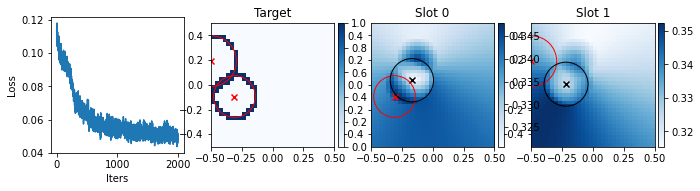

iter 2100 , loss 0.050937485 , lr 0.00029139224866249


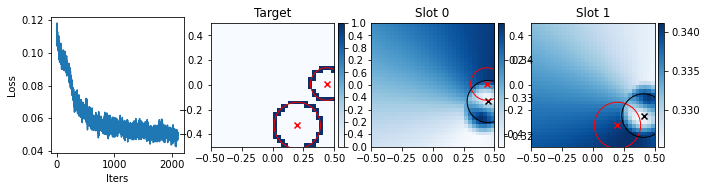

iter 2200 , loss 0.048395723 , lr 0.0002909885731025204


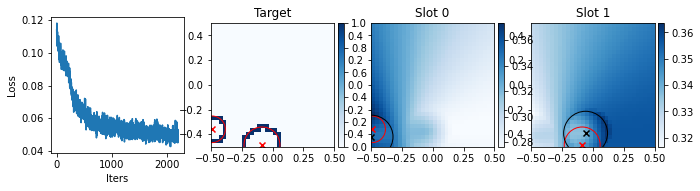

iter 2300 , loss 0.047143877 , lr 0.0002905854567679883


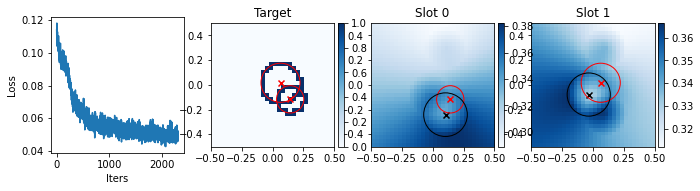

iter 2400 , loss 0.046021085 , lr 0.0002901828988841796


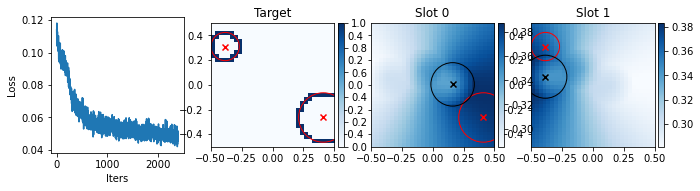

iter 2500 , loss 0.045775592 , lr 0.00028978089867745364


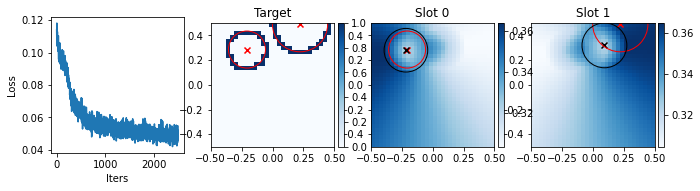

iter 2600 , loss 0.051310025 , lr 0.00028937945537524146


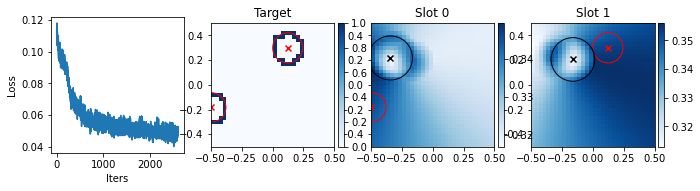

iter 2700 , loss 0.052120276 , lr 0.00028897856820604435


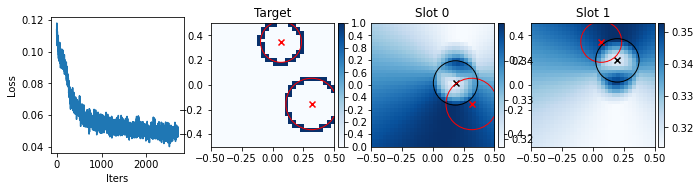

iter 2800 , loss 0.04346727 , lr 0.00028857823639943237


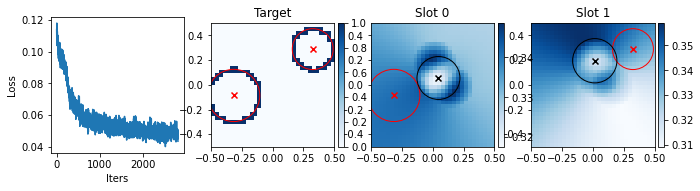

iter 2900 , loss 0.04602411 , lr 0.00028817845918604297


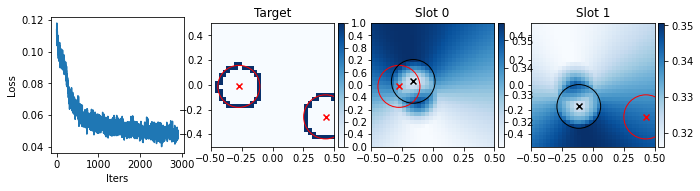

iter 3000 , loss 0.047971413 , lr 0.00028777923579757927


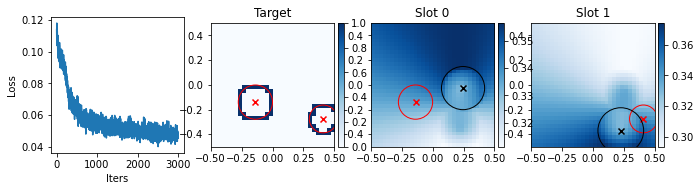

iter 3100 , loss 0.04855181 , lr 0.0002873805654668089


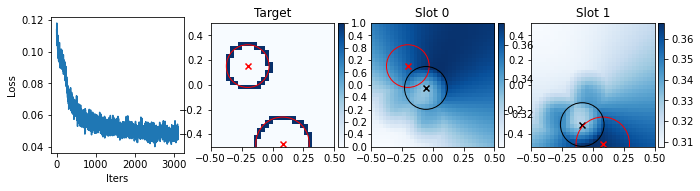

iter 3200 , loss 0.045013458 , lr 0.00028698244742756226


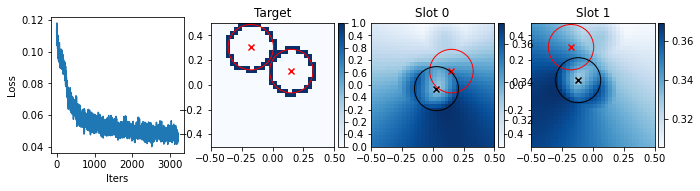

iter 3300 , loss 0.049508557 , lr 0.0002865848809147312


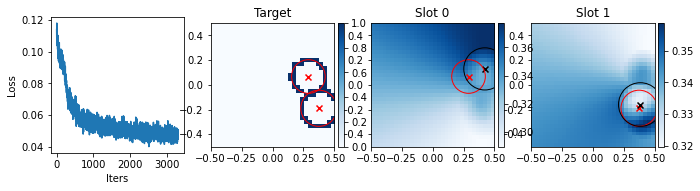

iter 3400 , loss 0.04475246 , lr 0.0002861878651642674


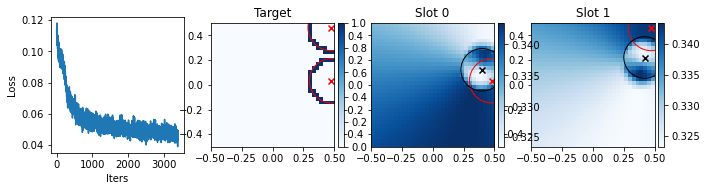

iter 3500 , loss 0.0472733 , lr 0.00028579139941318116


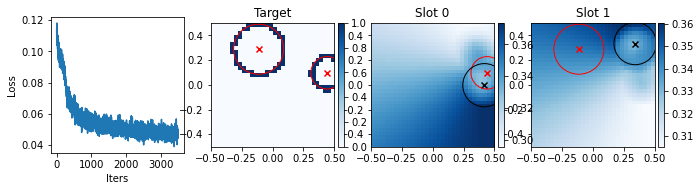

iter 3600 , loss 0.047616772 , lr 0.0002853954828995397


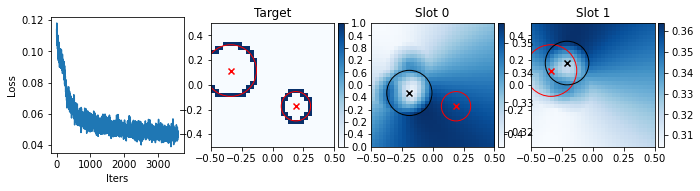

iter 3700 , loss 0.04746891 , lr 0.0002850001148624658


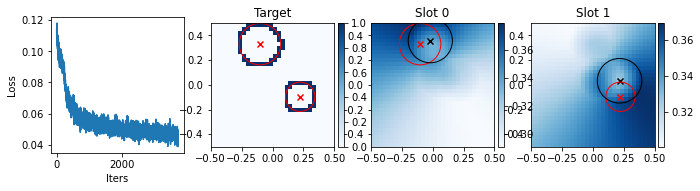

iter 3800 , loss 0.04872953 , lr 0.00028460529454213613


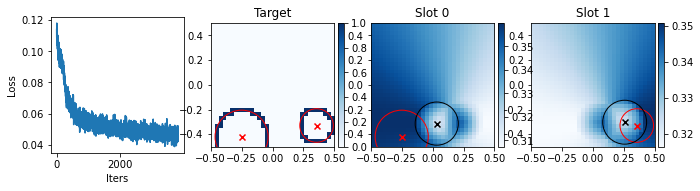

iter 3900 , loss 0.046024486 , lr 0.0002842110211797803


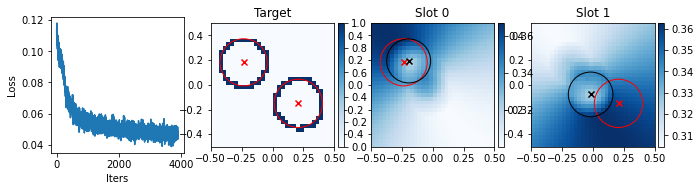

iter 4000 , loss 0.04763406 , lr 0.00028381729401767876


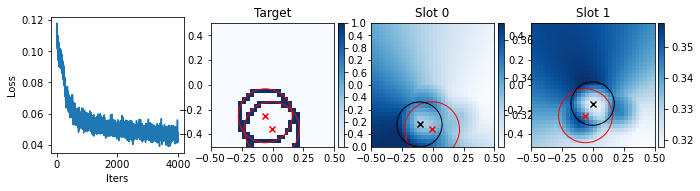

iter 4100 , loss 0.043895286 , lr 0.00028342411229916183


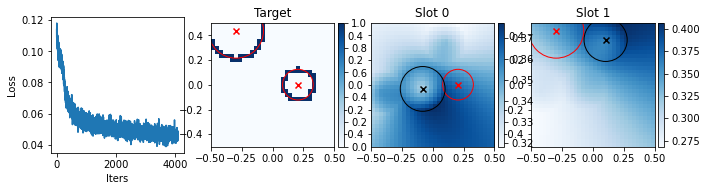

iter 4200 , loss 0.04127212 , lr 0.000283031475268608


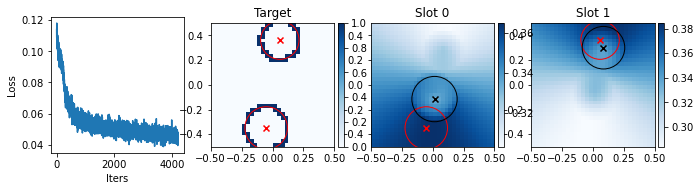

iter 4300 , loss 0.04575021 , lr 0.0002826393821714426


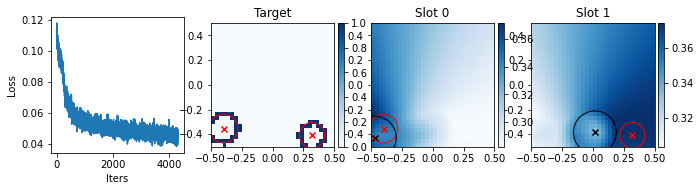

iter 4400 , loss 0.045825176 , lr 0.0002822478322541363


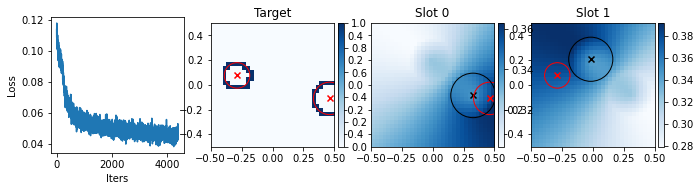

iter 4500 , loss 0.046907376 , lr 0.0002818568247642035


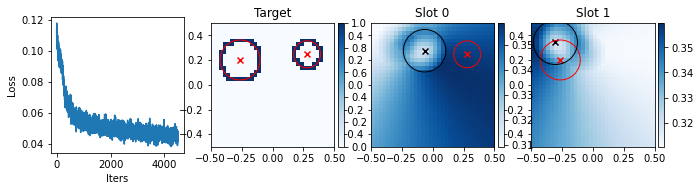

iter 4600 , loss 0.04589521 , lr 0.00028146635895020134


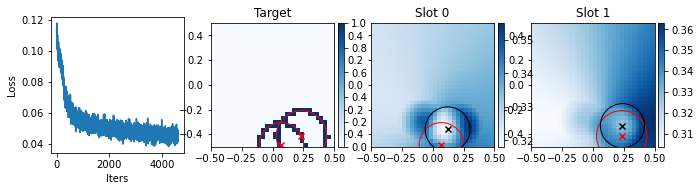

iter 4700 , loss 0.046331987 , lr 0.00028107643406172765


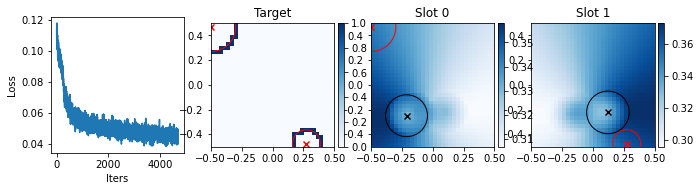

iter 4800 , loss 0.043722432 , lr 0.00028068704934942


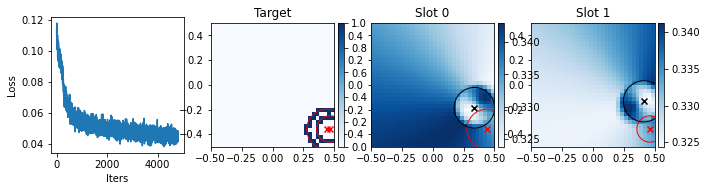

iter 4900 , loss 0.04471589 , lr 0.0002802982040649541


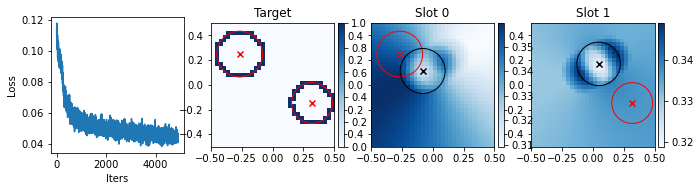

iter 5000 , loss 0.046424057 , lr 0.0002799098974610422


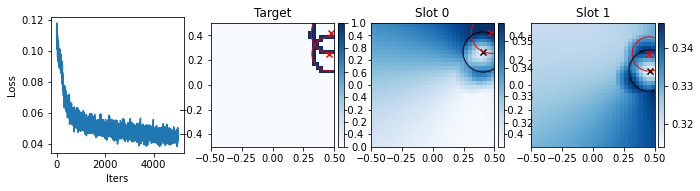

In [228]:
m, losses = train(m, bs=256, Ntrain=5_000, warmup_steps=1_000,
                  plot_every=100, device=device)

OK, the attention maps look a little wierd.
I think it's b/c I'm looking at them after the normalization, but I'm sort of thinking that this isnm't the right way to solve this problem right now to be honest.

Based on coding stuff up... I think I should just use this as a final postprocessing step?
But, I guess tbd :) 

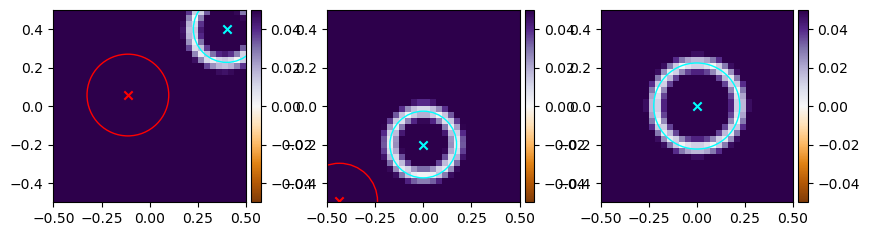

In [366]:
iEvt = 0

fig, ax = plt.subplots(1,3,figsize=(10,2.5))

extent = [-0.5,0.5]*2
for i_slot, (axi,li,qi) in enumerate(zip(ax,logits[iEvt],
                                         queries[iEvt].detach().numpy())):
    
    im = axi.imshow(li.reshape(32,32).detach().numpy(),
                    cmap='PuOr',vmax=.05,vmin=-.05,
                    extent=extent,origin='lower')

    divider = make_axes_locatable(axi)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    
    axi.scatter(*qi[:2],marker='x',color='cyan')
    circle = Circle(qi[:2],np.exp(qi[2]),fill=False,color='cyan')
    axi.add_patch(circle)
        
for axi,yi in zip(ax,Y[iEvt]):
    axi.scatter(*yi[:2],marker='x',color='r')
    circle = Circle(yi[:2],yi[2],fill=False,color='r')
    axi.add_patch(circle)
    
    axi.set_xlim(-0.5,0.5)
    axi.set_ylim(-0.5,0.5)
    
plt.show()